In [50]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import matplotlib.pyplot as plt
import numpy as np
import emd
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from statistics import mean
import statistics

In [52]:
def load_nysm_data():
    # these parquet files are created by running "get_resampled_nysm_data.ipynb"
    nysm_path = "/home/aevans/nwp_bias/data/nysm/"

    nysm_1H = []
    for year in np.arange(2018, 2023):
        df = pd.read_parquet(f"{nysm_path}nysm_1H_obs_{year}.parquet")
        df.reset_index(inplace=True)
        nysm_1H.append(df)
    nysm_1H_obs = pd.concat(nysm_1H)
    nysm_1H_obs["snow_depth"] = nysm_1H_obs["snow_depth"].fillna(-999)
    nysm_1H_obs.dropna(inplace=True)
    return nysm_1H_obs

In [86]:
def groupby_month(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.time_1H.dt.year), (df.time_1H.dt.month)])[col].var()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(12, 9))
    plt.plot(the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, 60, 12))

In [87]:
# import data
df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/clean_parquets/met_geo_cats/cleaned_rough_lstm_geo_met_cat_orange.parquet"
)
df.head()

,valid_time,time,station_ADDI,latitude_ADDI,longitude_ADDI,t2m_ADDI,sh2_ADDI,d2m_ADDI,r2_ADDI,u10_ADDI,...,26_aspect_WBOU,31_aspect_WBOU,33_aspect_WBOU,32_aspect_WBOU,34_aspect_WBOU,38_aspect_WBOU,std_elev_WBOU,variance_elev_WBOU,skew_elev_WBOU,med_dist_elev_WBOU
0,2018-01-01 03:00:00,2018-01-01 01:00:00,ADDI,42.045955,-77.218867,-19.199194,0.00068,-21.993216,76.800003,3.321081,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986
1,2018-01-01 04:00:00,2018-01-01 02:00:00,ADDI,42.045955,-77.218867,-19.118689,0.00068,-21.918570,76.500000,3.298830,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986
2,2018-01-01 05:00:00,2018-01-01 03:00:00,ADDI,42.045955,-77.218867,-19.439062,0.00065,-22.570868,73.800003,2.992857,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986
3,2018-01-01 06:00:00,2018-01-01 04:00:00,ADDI,42.045955,-77.218867,-19.760291,0.00063,-22.821158,74.400002,3.115693,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986
4,2018-01-01 07:00:00,2018-01-01 05:00:00,ADDI,42.045955,-77.218867,-19.860175,0.00062,-22.993704,74.099998,3.268302,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986


In [88]:
nysm_df = load_nysm_data()
nysm_df = nysm_df[nysm_df["station"] == "OLEA"]
nysm_df = nysm_df[nysm_df["tair"] > -100]
nysm_df.dropna(inplace=True)

In [89]:
nysm_df.keys()

Index(['station', 'time_1H', 'lat', 'lon', 'elev', 'tair', 'ta9m', 'td',
       'relh', 'srad', 'pres', 'mslp', 'wspd_sonic', 'wmax_sonic',
       'wdir_sonic', 'precip_total', 'snow_depth'],
      dtype='object')

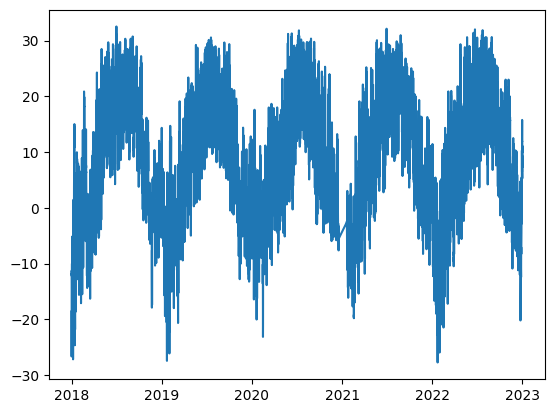

In [90]:
plt.plot(nysm_df["time_1H"], nysm_df["tair"])

/tmp/tmp.O5HovjdaW4/ipykernel_3927509/707800886.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


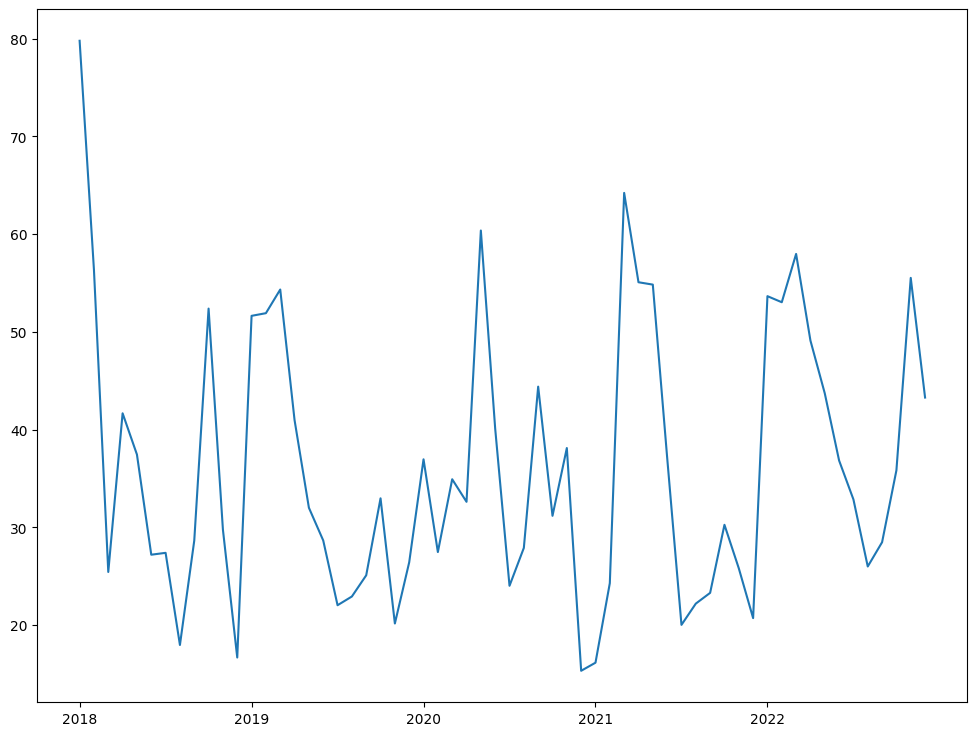

In [91]:
groupby_month(nysm_df, "tair")

/tmp/tmp.O5HovjdaW4/ipykernel_3927509/707800886.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


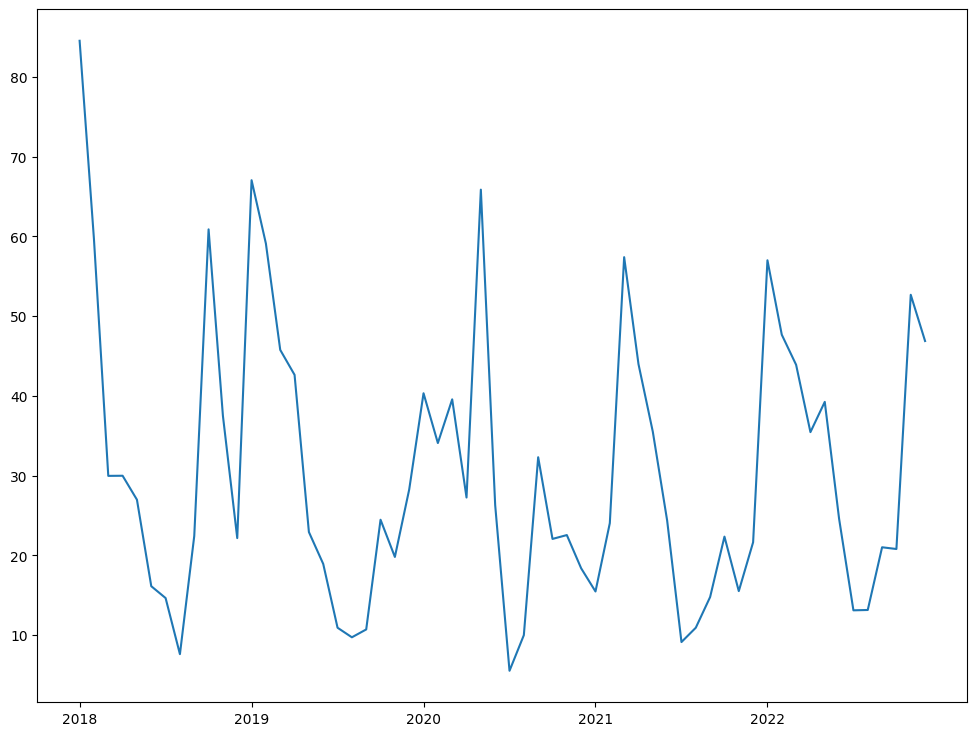

In [92]:
groupby_month(nysm_df, "td")

/tmp/tmp.O5HovjdaW4/ipykernel_3927509/707800886.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


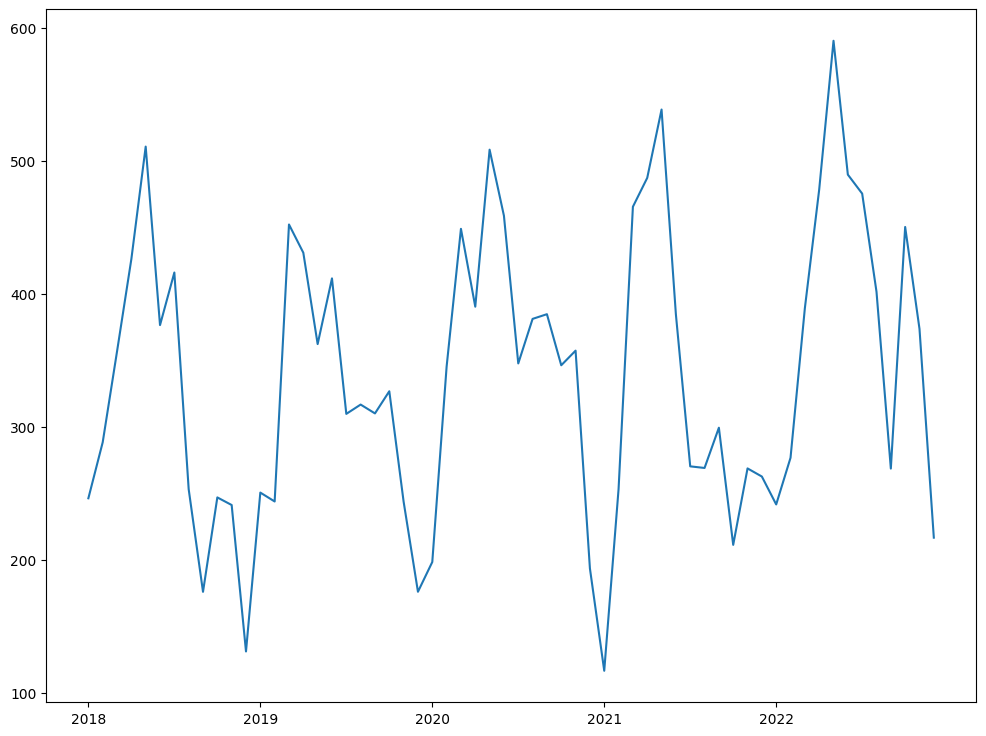

In [93]:
groupby_month(nysm_df, "relh")

/tmp/tmp.O5HovjdaW4/ipykernel_3927509/707800886.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


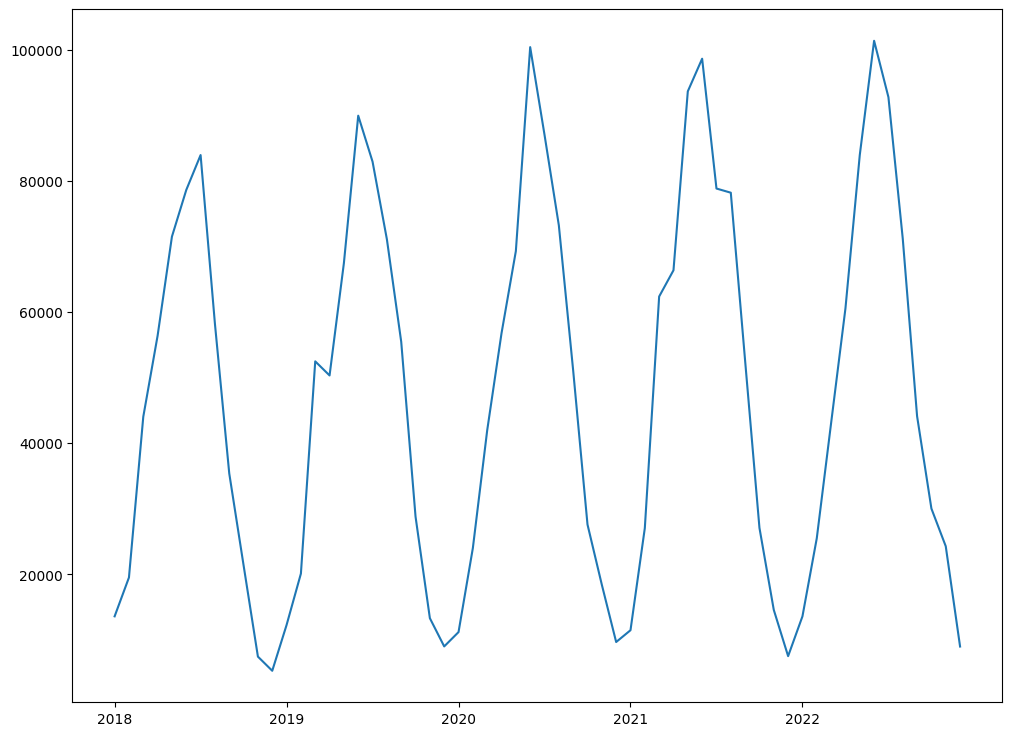

In [94]:
groupby_month(nysm_df, "srad")

/tmp/tmp.O5HovjdaW4/ipykernel_3927509/707800886.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


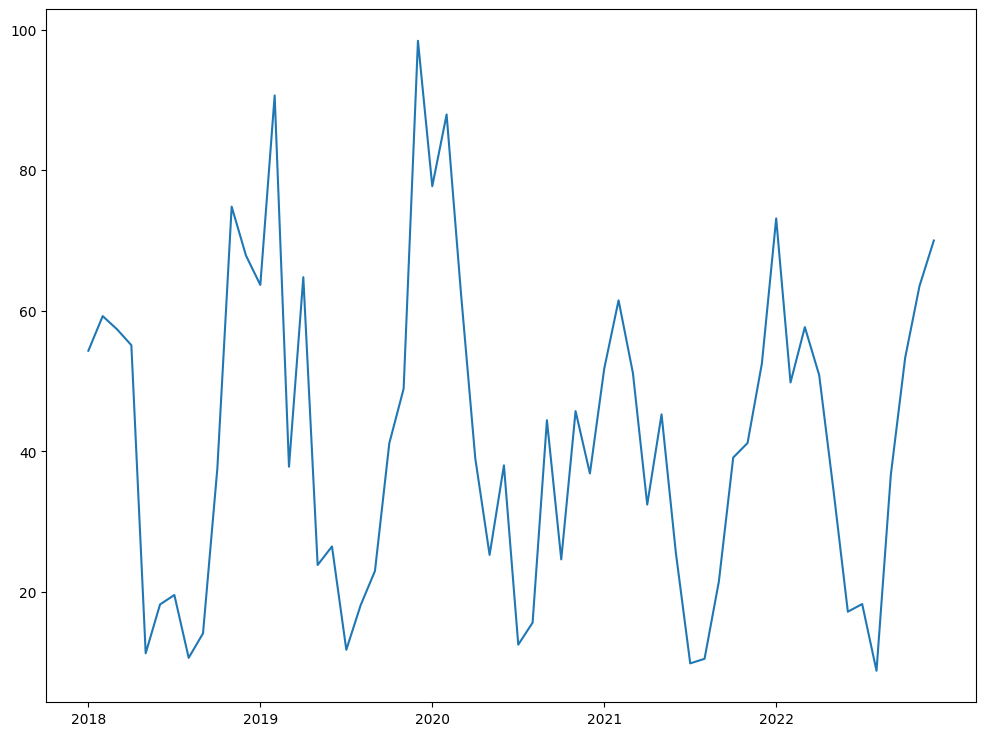

In [95]:
groupby_month(nysm_df, "pres")

/tmp/tmp.O5HovjdaW4/ipykernel_3927509/707800886.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


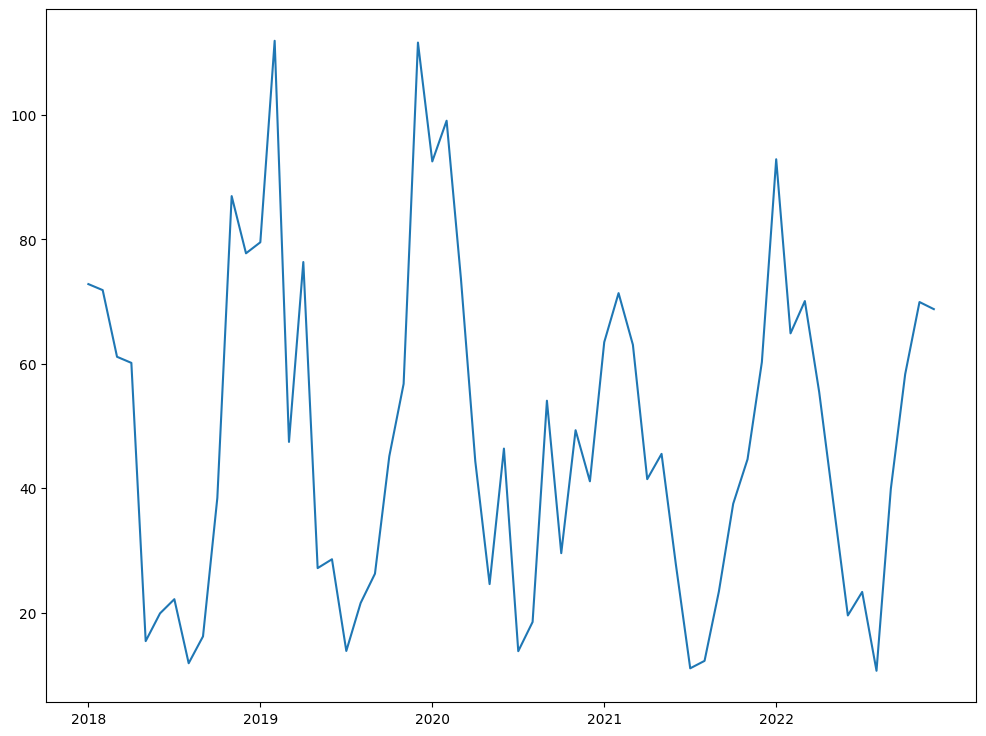

In [96]:
groupby_month(nysm_df, "mslp")

/tmp/tmp.O5HovjdaW4/ipykernel_3927509/707800886.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


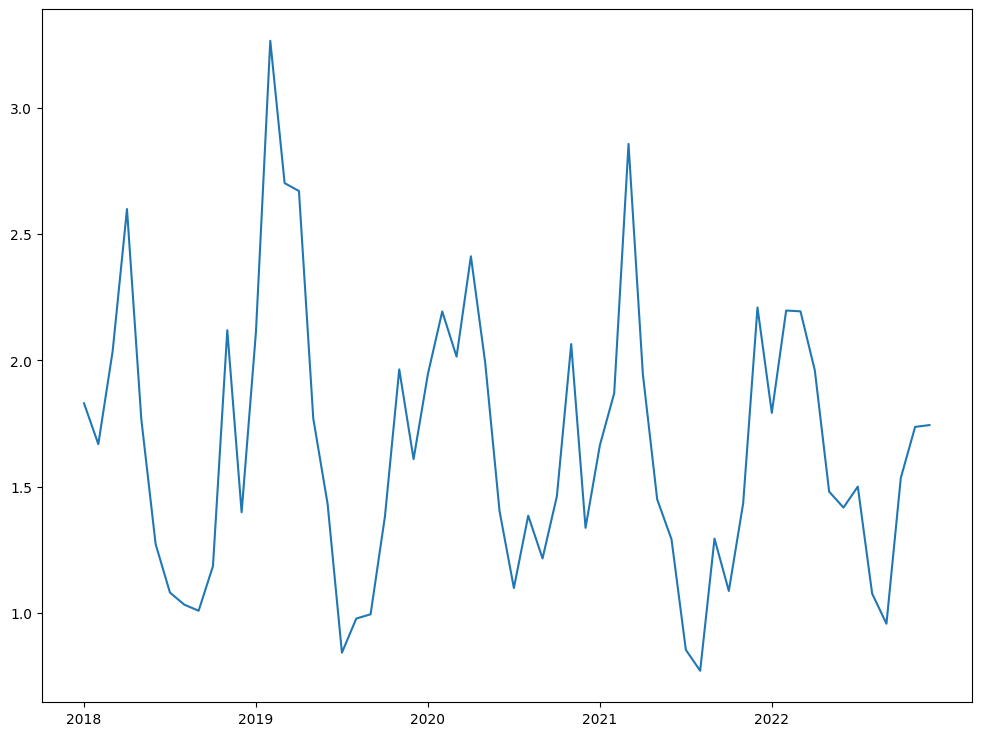

In [97]:
groupby_month(nysm_df, "wspd_sonic")

/tmp/tmp.O5HovjdaW4/ipykernel_3927509/707800886.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


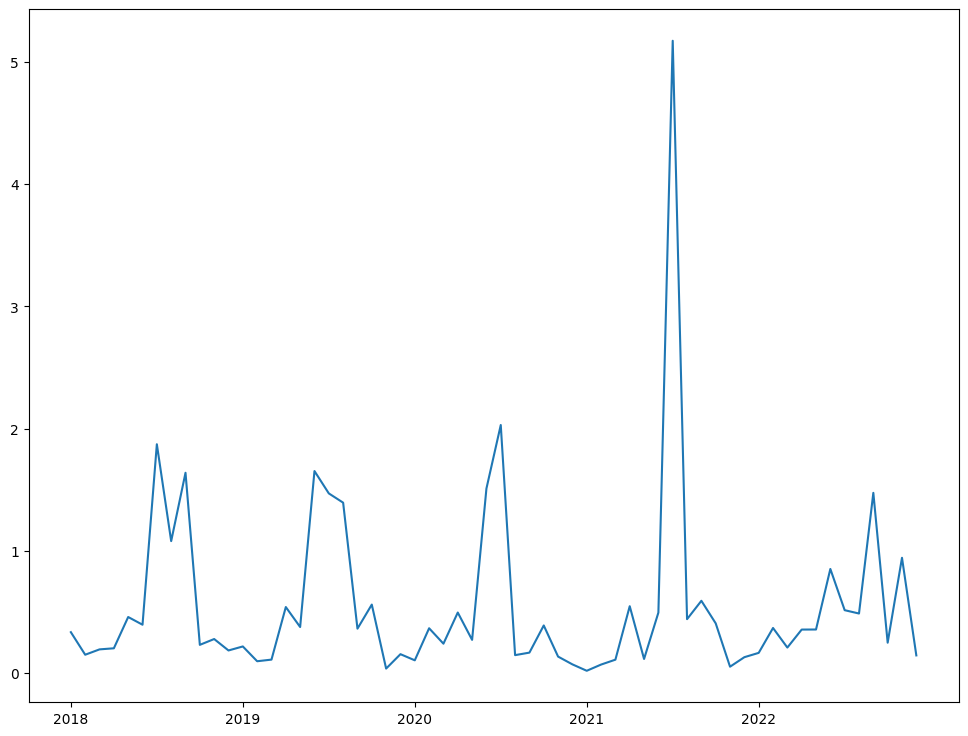

In [98]:
groupby_month(nysm_df, "precip_total")

/tmp/tmp.O5HovjdaW4/ipykernel_3927509/707800886.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


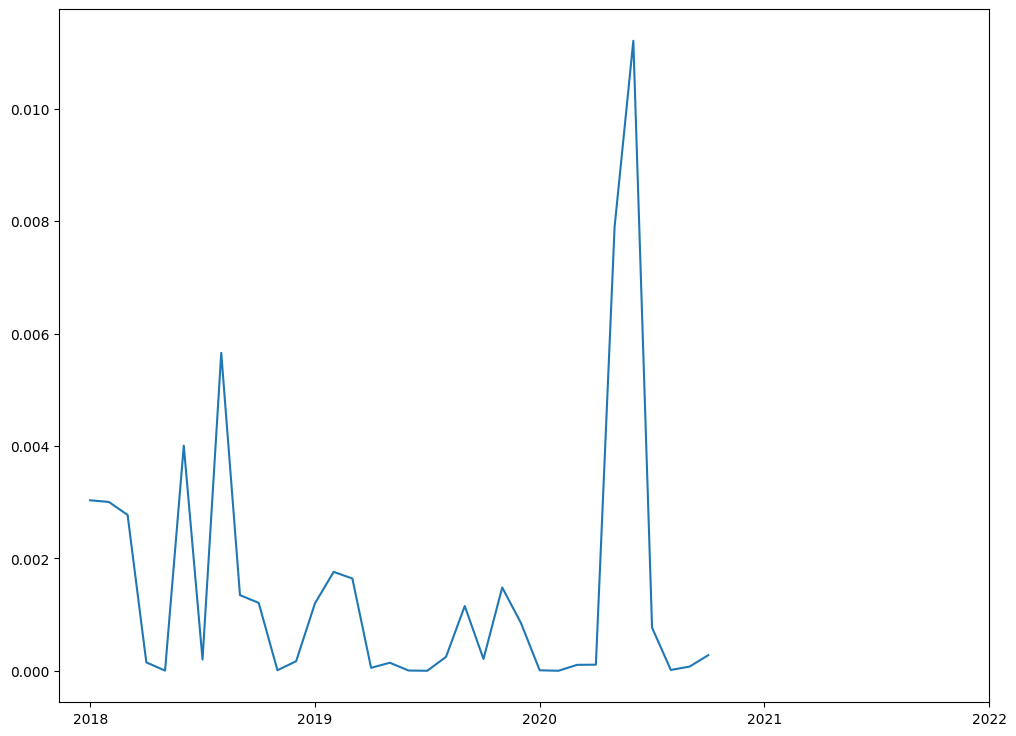

In [99]:
groupby_month(nysm_df, "snow_depth")

In [100]:
# now we can estimate the IMFs for the signal
x = nysm_df["tair"]
imf = emd.sift.sift(x)
print(imf.shape)

/home/aevans/miniconda3/lib/python3.9/site-packages/emd/support.py:228: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]


(42946, 10)


and, from the IMFs, compute the instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method:

In [101]:
IP, IF, IA = emd.spectra.frequency_transform(imf, 23618, "hilbert")

From the instantaneous frequency and amplitude, we can compute the Hilbert-Huang spectrum:

In [102]:
# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (0.1, 10, 80, "log")
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

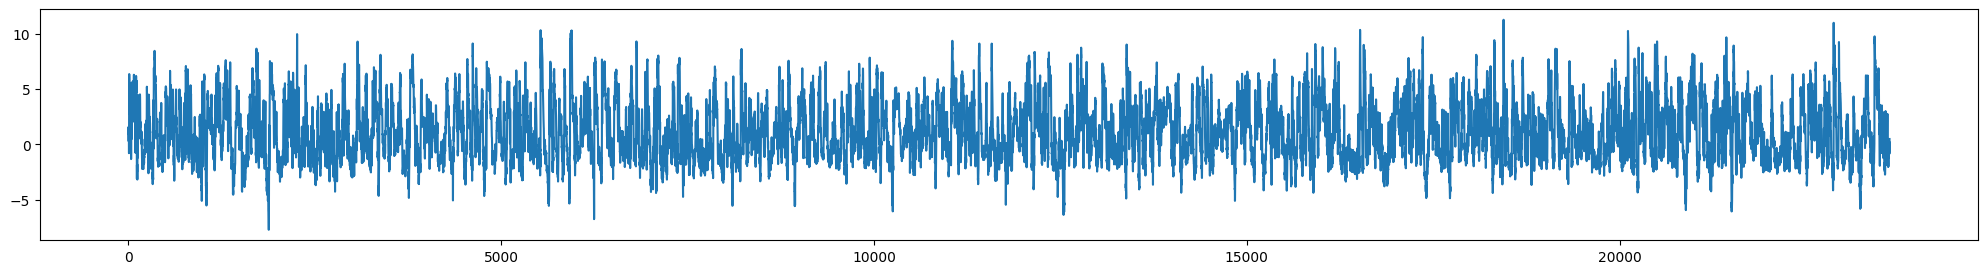

In [103]:
# visualize
fig = plt.figure(figsize=(25, 3))
plt.plot(nysm_df["tair"])

In [104]:
df.iloc[:, 9:11]

,u10_ADDI,v10_ADDI
0,3.321081,-2.272873
1,3.298830,-1.821096
2,2.992857,-0.877062
3,3.115693,-0.789671
4,3.268302,-0.054269
...,...,...
23613,0.073768,5.399014
23614,-0.416093,5.292988
23615,0.234075,5.295895
23616,0.285457,5.515205


Plot the IMFs

<Axes: xlabel='Time (samples)'>

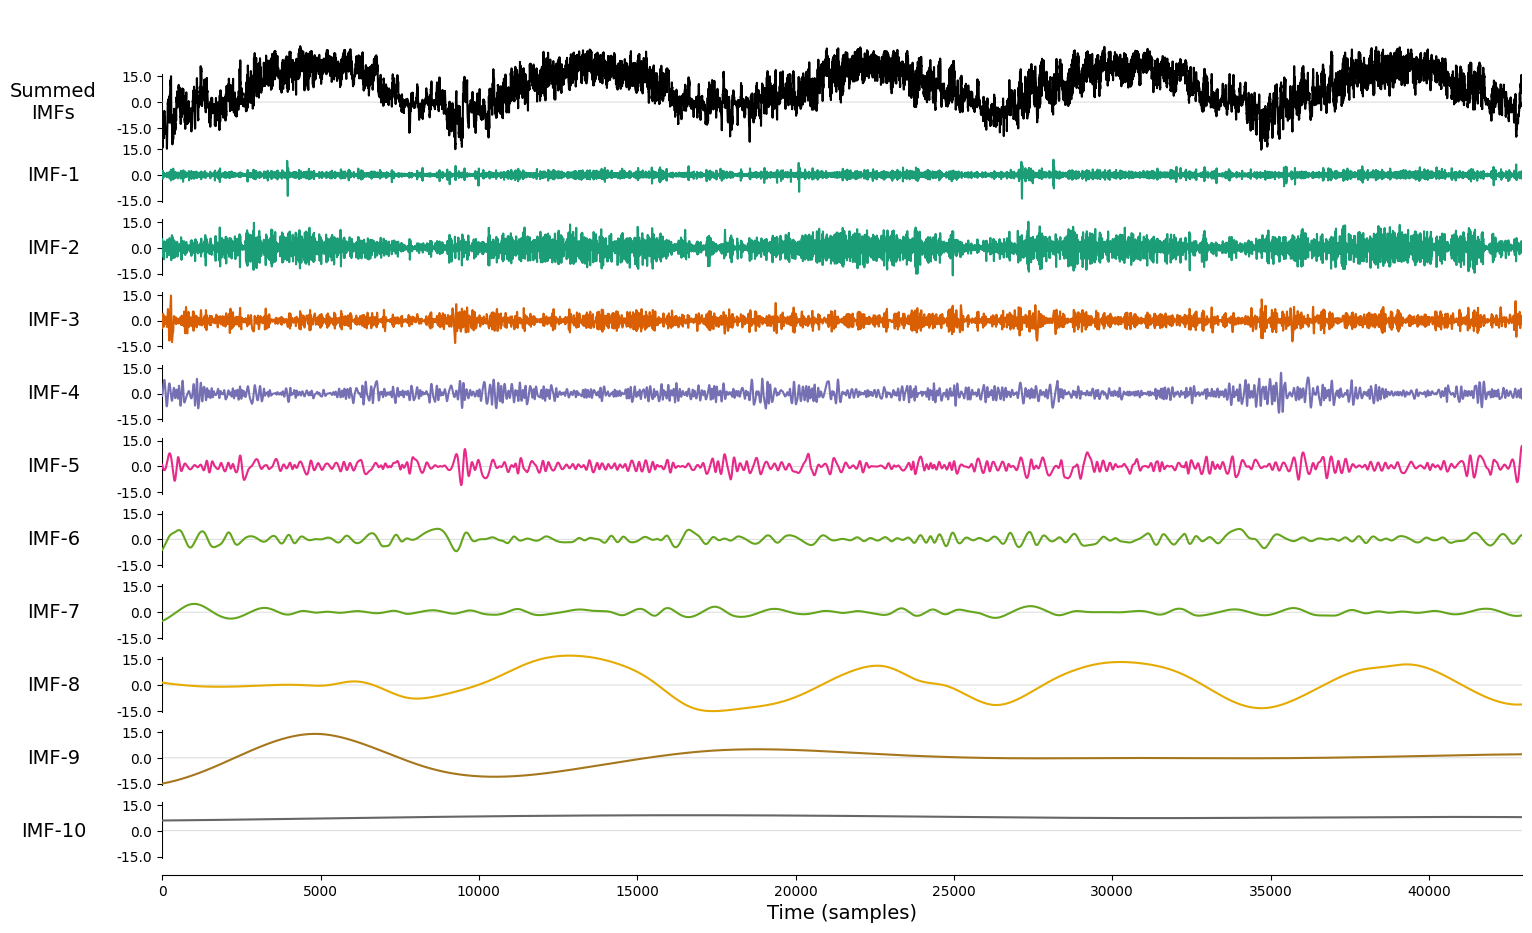

In [105]:
emd.plotting.plot_imfs(imf)

<Axes: title={'center': 'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

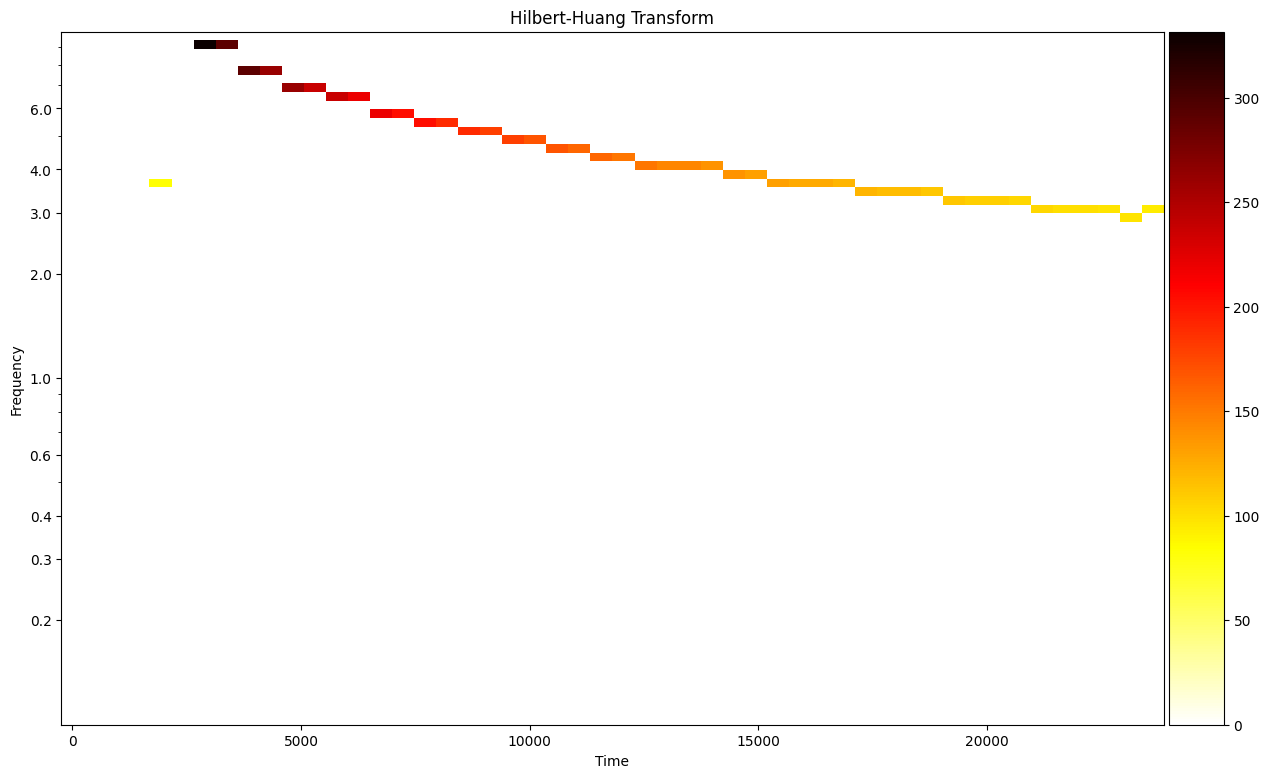

In [106]:
sample_rate = 23618
time_vect = np.linspace(0, sample_rate)
fig = plt.figure(figsize=(15, 9))
emd.plotting.plot_hilberthuang(hht, time_vect, f, fig=fig, log_y=True)

# ensemble sifting 

In [107]:
imf_opts = {"sd_thresh": 0.05}

/home/aevans/miniconda3/lib/python3.9/site-packages/emd/support.py:228: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]


<Axes: xlabel='Time (samples)'>

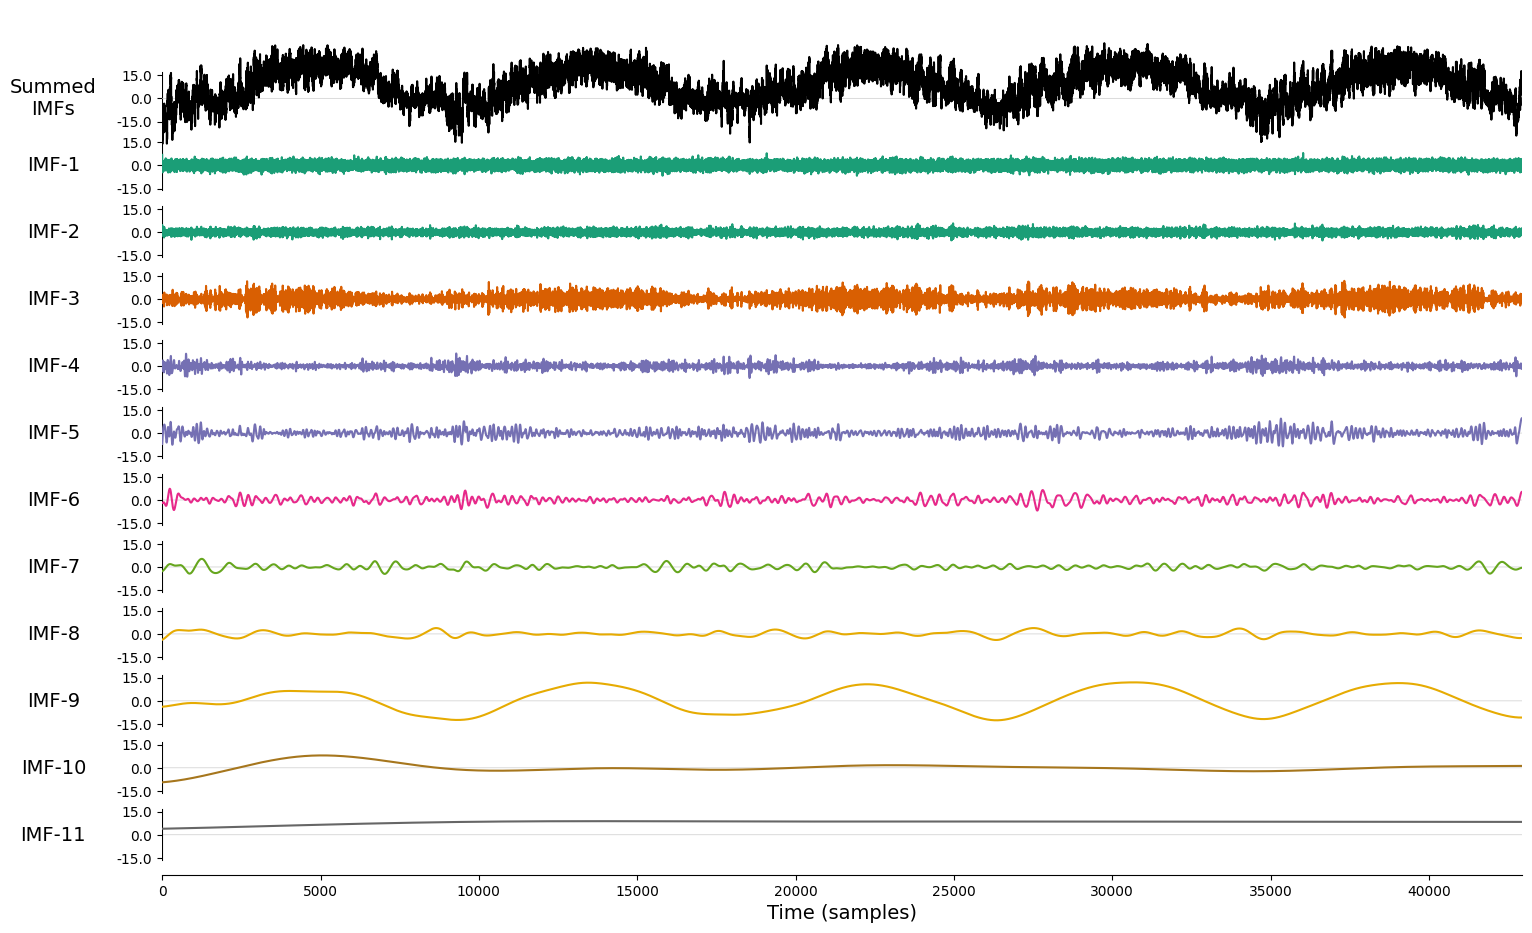

In [108]:
imf = emd.sift.ensemble_sift(
    x, nensembles=42, nprocesses=12, ensemble_noise=1, imf_opts=imf_opts
)
emd.plotting.plot_imfs(imf)

In [109]:
imf.shape

(42946, 11)

and now the Hilbert-Huang transform of this decomposition

In [110]:
sample_rate = 23618

time_vect = np.linspace(0, sample_rate - 0.5)

<Axes: title={'center': 'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

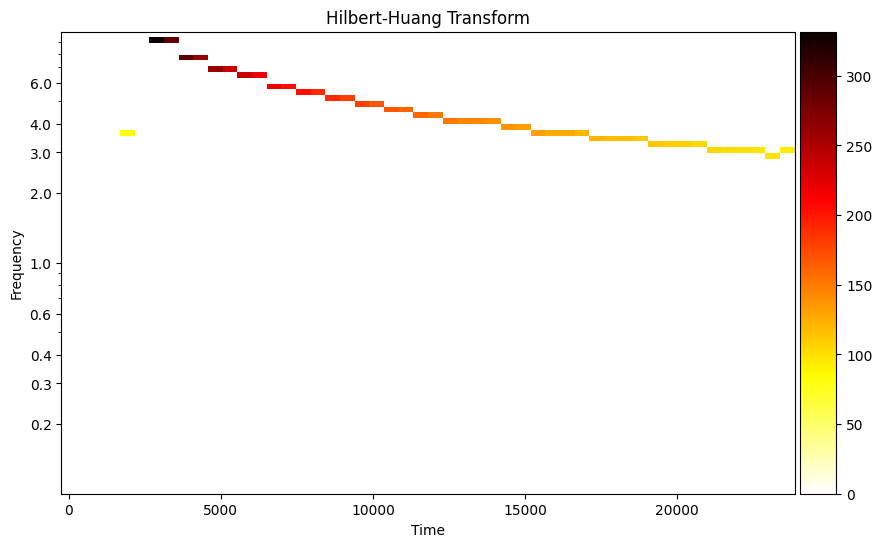

In [111]:
fig = plt.figure(figsize=(10, 6))
emd.plotting.plot_hilberthuang(hht, time_vect, f, fig=fig, log_y=True)